#### Reading the data and some information   
   1. [Reading the data](#one)
   2. [check for null values](#check_fo_null_values)   
   3. [what country has the most and least number of data points](#m)  
   4. [Visualization](#Visualization)  
   5. [making API call](#making_API_call)  
   6. [saving data](#saving_data)
   
#### proccessing the data
   1. [Reading the tweets (phase 1)](#phase1)
   2. [Removing mentions](#mentions)
   4. [remove links](#links)
   5. [normalize some letters](#letters)
   6. [remove hashtags](#hashtags)
   7. [remove التشكيل and emoji, numbers and punctuations](#remove)
   8. [remove rpeated letters](#repeated)
   9. [lemmatization](#lemmatization)
   10. [Function to processs the data](#processs)
   11. [saving the data](#saving)   
   

In [2]:
import itertools
import pandas as pd
import json
import requests
import re
from farasa.stemmer import FarasaStemmer
import pyarabic.araby as araby
from pyarabic.araby import tokenize, is_arabicrange, strip_tashkeel
import numpy as np
import time

### Reading the data<a id='one'></a>

In [17]:
URL = 'https://recruitment.aimtechnologies.co/ai-tasks'
df = pd.read_csv('dialect_dataset.csv', dtype=str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  object
 1   dialect  458197 non-null  object
dtypes: object(2)
memory usage: 7.0+ MB


### check for null values<a id='check_fo_null_values'></a>

In [4]:
np.sum(df.isnull().any(axis=1))

0

### what country has the most and least number of data points<a id='m'></a>

In [5]:
dialects = df.groupby('dialect').count()
minimum = np.argmin(df.groupby('dialect').count())
maximum = np.argmax(df.groupby('dialect').count())
print(dialects.iloc[maximum], 'Egypt')
print(dialects.iloc[minimum], 'Tunisia')

id    57636
Name: EG, dtype: int64 Egypt
id    9246
Name: TN, dtype: int64 Tunisia


### Visualization<a id='Visualization'></a>

<AxesSubplot:title={'center':'Distribution of data'}, xlabel='dialect'>

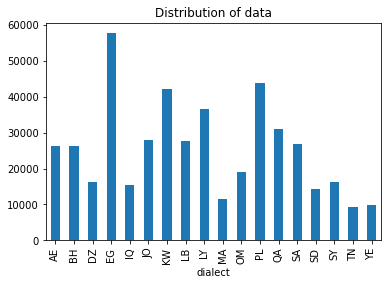

In [6]:
df.groupby('dialect').count().plot(kind='bar', title='Distribution of data',legend=False)

#### making API calls<a id='making_API_call'></a>

In [23]:
batches = df.shape[0]//1000
size = 1000
data_id = [] 
data_tweets = []
for batch in range(batches+1):
    #print("===========================")
    ids = np.array(df['id'][size*batch:size*batch+size]).tolist()
    data_id.extend(ids)
    try:
        req = requests.post(URL, json= ids)
    except:
        time.sleep(60)
        req = requests.post(URL, json= ids)
    data_tweets.extend(req.json().values())

ids = np.array(df['id'][size*(batch+1):]).tolist()
data_id.extend(ids)
req = requests.post(URL, json= ids)
data_tweets.extend(req.json().values())
dataset = pd.DataFrame({'dialect': df['dialect'], 'tweet': data_tweets})
#, 'pure_tweet': data_tweets

#### saving the data<a id='saving_data'></a>

In [146]:
dataset.to_csv('dataset_with_tweets.csv', index=False)

Number of samples

In [36]:
len(df)

458197

#### Reading the tweets (phase 1)<a id='phase1'></a>

In [2]:
dataset = pd.read_csv('dataset_with_tweets.csv')

### Removing mentions<a id='mentions'></a>

In [3]:
def remove_mentions(text):
    return re.sub("@[A-Za-z0-9_]+","", text)

### Removing links<a id='links'></a>

In [4]:
def remove_links(text):
    return re.sub(r"http\S+", "", text)

### Normalizing Arabic letters<a id='letters'></a>

In [5]:
def normalizeArabic(text):
    text = text.replace("أ", "ا" )
    text = text.replace("إ", "ا")
    text = text.replace("آ", "ا" )
    text = text.replace("ى", "ي")
    text = text.replace("ة","ه")
    text = text.replace('اً', 'ا')
    return(text)

### Removing hashtags<a id='hashtags'></a>

In [82]:
def remove_hashtags(text):
    #return " ".join(filter(lambda text:text[0]!='#', text.split()))
    st = '# _'
    for i, letter in enumerate(text):
        if letter in st:
            text = text.replace(letter," ")
    return text

### Remove <a id='remove'></a> التشكيل and emoji, numbers and punctuations

In [83]:
def remove_el_tashkeel_and_other_non_letters(text):
    text = tokenize(text, conditions=is_arabicrange, morphs=strip_tashkeel)
    
    return ' '.join(text)

### Remove repeated letters<a id='repeated'></a>

In [8]:
def remove_repeated_letters(text):
    # words like ههههههه will be ه
    # جدااااا will be جدا
    return ''.join(c for c, _ in itertools.groupby(text))

### lemmatization<a id='lemmatization'></a>

In [48]:
stemmer_interactive = FarasaStemmer(interactive=True)
def lemmatization(text):
    stemmed_interactive = stemmer_interactive.stem(text)
    return stemmed_interactive

[2022-03-09 21:03:23,181 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


# Function to processs the data<a id='processs'></a>

In [88]:
# proccess
def preprocess(text):
    text = remove_mentions(text)
    text = remove_links(text)
    text = normalizeArabic(text)
    text = remove_hashtags(text)
    text = remove_el_tashkeel_and_other_non_letters(text)
    text = remove_repeated_letters(text)
    text = lemmatization(text)
    return text
dataset['pure_tweet'] = dataset['tweet'].apply(lambda x: preprocess(x))

#### saving the data (phase 2)<a id='saving'></a>

In [93]:
dataset.to_csv('preprocessed_data.csv', index=False)

In [94]:
stemmer_interactive.terminate()